# 12 Clipping

In this lesson we will learn how to to clip different geometries.

## About the data

We will use three datasets in this lesson. 

The first dataset is a [TIGER shapefile of the US states from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). Follow these steps to download shapefile with the United States' states:

You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

The second dataset we'll use is [Natural Earth's simple medium scale populated places dataset](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). We can obtain this dataset by downloading the shapefile (choose the one that says "simple (less columns)").

The third dataset we'll use is [Natural Earth's road dataset](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/roads/). 
We can obtain this dataset by downloading the shapefile 

We will combine these datasets to create the following map of infrastructure in Alaska:

## Import data

Let's start by loading our libraries and then importing the datasets we will use.


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import box  # To create polygon bounding box

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

pd.set_option("display.max.columns", None)

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', 
                              'data')

# Import and simplify states polygons
states = gpd.read_file(os.path.join(data_folder_fp, 
                                    'tl_2022_us_state', 
                                    'tl_2022_us_state.shp'))

# Import Natural Earth populated places points
places = gpd.read_file(os.path.join(data_folder_fp,
                                    'ne_50m_populated_places',
                                    'ne_50m_populated_places.shp')
                                    )

# Import ferry routes lines
roads = gpd.read_file(os.path.join(data_folder_fp,
                                   'ne_10m_roads',
                                   'ne_10m_roads.shp')
                                   )

## Check-in
Use a for loop to iterate over the three geo-dataframes we imported and change their column names to lower caps.

In [10]:
for df in [states, places, roads]:
    df.columns = df.columns.str.lower()

## Prepare Alaska multipolygon

This is a geospatial dataset, you should always *at least* check the following:

CRS, plotting the data, and head of the dataset.

In [12]:
states.crs

<Geographic 2D CRS: GEOGCS["GCS_North_American_1983",DATUM["D_North_Am ...>
Name: NAD83
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
states.head(3)

,region,division,statefp,statens,geoid,stusps,name,lsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266456923,489045863,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138962819934,45971472526,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778515726,6216539665,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."


<Axes: >

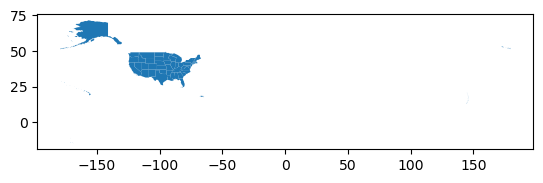

In [14]:
states.plot()

For this lesson, we are interested in plotting data in Alaska only.

<Axes: >

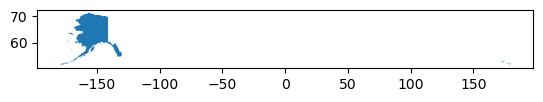

In [15]:
alaska = states[states.name == "Alaska"]
alaska.plot()

Notice the multipolygon is plotted under the NAD83/EPSG:4269 CTS (common for US agencies data) and this unnaturally elongates the map. 

Let's reproject to EPSG:3338, this is a *projected* CRS.

In [16]:
# Reproject to CRS optimized for Alaska
alaska = alaska.to_crs('epsg:3338')

# Inspect new CRS
print("Is this CRS projected?", alaska.crs.is_projected)
alaska.crs

# geographic is degree, projected is in meters

Is this CRS projected? True


<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meter)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

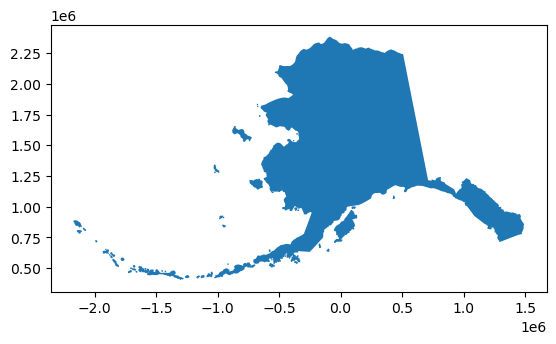

In [17]:
alaska.plot()

## Prepare populated places points

Let's explore the data:

In [18]:
places.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
places.head(3)

,scalerank,natscale,labelrank,featurecla,name,namepar,namealt,nameascii,adm0cap,capin,worldcity,megacity,sov0name,sov_a3,adm0name,adm0_a3,adm1name,iso_a2,note,latitude,longitude,pop_max,pop_min,pop_other,rank_max,rank_min,meganame,ls_name,max_pop10,max_pop20,max_pop50,max_pop300,max_pop310,max_natsca,min_areakm,max_areakm,min_areami,max_areami,min_perkm,max_perkm,min_permi,max_permi,min_bbxmin,max_bbxmin,min_bbxmax,max_bbxmax,min_bbymin,max_bbymin,min_bbymax,max_bbymax,mean_bbxc,mean_bbyc,timezone,un_fid,pop1950,pop1955,pop1960,pop1965,pop1970,pop1975,pop1980,pop1985,pop1990,pop1995,pop2000,pop2005,pop2010,pop2015,pop2020,pop2025,pop2050,min_zoom,wikidataid,wof_id,capalt,name_en,name_de,name_es,name_fr,name_pt,name_ru,name_zh,label,name_ar,name_bn,name_el,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_sv,name_tr,name_vi,ne_id,name_fa,name_he,name_uk,name_ur,name_zht,geonamesid,fclass_iso,fclass_us,fclass_fr,fclass_ru,fclass_es,fclass_cn,fclass_tw,fclass_in,fclass_np,fclass_pk,fclass_de,fclass_gb,fclass_br,fclass_il,fclass_ps,fclass_sa,fclass_eg,fclass_ma,fclass_pt,fclass_ar,fclass_jp,fclass_ko,fclass_vn,fclass_tr,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,fclass_tlc,geometry
0,10,1,5,Admin-1 region capital,Bombo,None,None,Bombo,0,None,0,0,Uganda,UGA,Uganda,UGA,Bamunanika,UG,None,0.583299,32.533300,75000,21000,0.0,8,7,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q4940747,1141906025,0,Bombo,Bombo,Bombo,Bombo,Bombo,Бомбо,邦博,None,بومبو,বোম্বো,Μπόμπο,बॉम्बो,Bombo,Bombo,Bombo,ボンボ,봄보,Bombo,Bombo,Bombo,Bombo,Bombo,1159113923,بمبو,בומבו,Бомбо,بومبو,邦博,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (32.53330 0.58330)
1,10,1,5,Admin-1 region capital,Fort Portal,None,None,Fort Portal,0,None,0,0,Uganda,UGA,Uganda,UGA,Kabarole,UG,None,0.671004,30.275002,42670,42670,0.0,7,7,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Africa/Kampala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q500107,421174009,0,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Форт-Портал,波特爾堡,None,فورت بورتال,ফোর্ট পোর্টাল,Φορτ Πορτάλ,फोर्ट पोर्टल,Fort Portal,Fort Portal,Fort Portal,フォート・ポータル,포트포털,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Fort Portal,1159113959,فورت پورتال,פורט פורטל,Форт-Портал,فورٹ پورٹل,波特爾堡,233476.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (30.27500 0.67100)
2,10,1,3,Admin-1 region capital,Potenza,None,None,Potenza,0,None,0,0,Italy,ITA,Italy,ITA,Basilicata,IT,None,40.642002,15.798997,69060,69060,0.0,8,8,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Europe/Rome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q3543,101752567,0,Potenza,Potenza,Potenza,Potenza,Potenza,Потенца,波坦察,None,بوتنسا,পোটেঞ্জা,Ποτέντσα,पोटेंजा,Potenza,Potenza,Potenza,ポテンツァ,포텐차,Potenza,Potenza,Potenza,Potenza,Potenza,1159117259,پوتنزا,פוטנצה,Потенца,پوتینتسا,波坦察,3170027.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (15.79900 40.64200)


<Axes: >

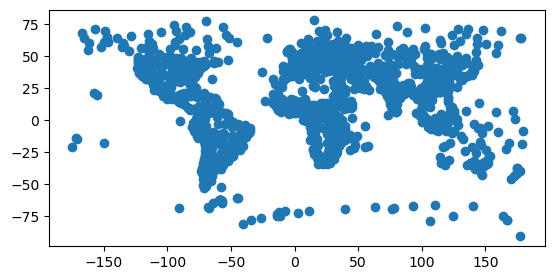

In [20]:
places.plot()

This dataset is in WGS 84/EPSG:4326 CRS.
This is the most widely used CRS for global data.
Let's try to plot it on top of Alaska:

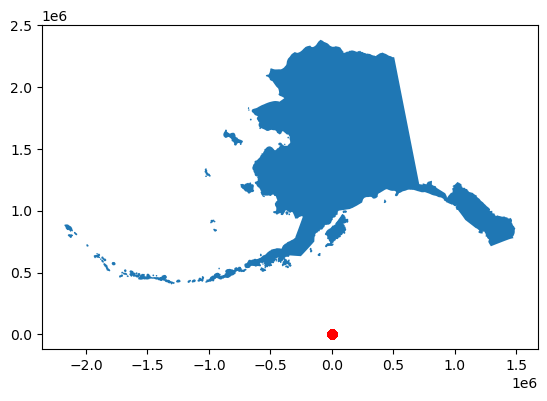

In [21]:
fig, ax = plt.subplots()

alaska.plot(ax = ax)
places.plot(ax = ax, color = "red")
plt.show()

**If your data is in a weird place, check that the CRSs match**

Let's update the CRS using an `if-else` statement:

In [24]:
if alaska.crs == places.crs:
    print("CRSs match!")
else:
    places = places.to_crs(alaska.crs)
    assert places.crs == alaska.crs
    print("We matched the CRSs!")

CRSs match


Remember that an `if-else` statement (control structure) allows code to make decisions:

- it checks a condition,
- if that condition is true, it executes one block of the code (the `if` block)
- if the condition is false, it executes a different block (the `else` block)

Indentation is important!

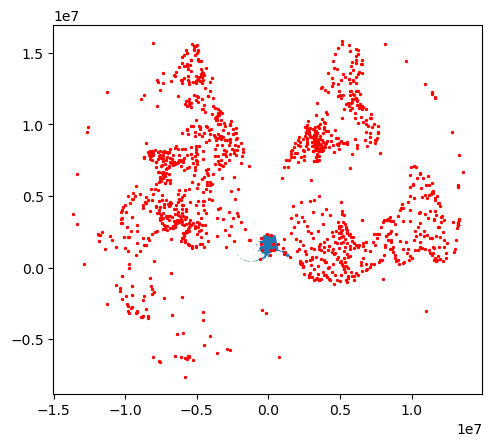

In [26]:
fig, ax = plt.subplots()

alaska.plot(ax = ax)
places.plot(ax = ax, color = "red", markersize = 2)
plt.show()

## Clipping

**Clipping** means using a polygon (or polygons) to select only geospatial data within them.
This is simple with a `geopandas.GeoDataFrame` using the `clip()` function:

```python
updated_geodf = geopandas.clip(geodf, mask)
```

where
- `updated_geodf` = output of the method, the **intersection** of the geometries in `geodf` with the `mask`
- `geodf` = `gpd.geodf` we want to clip
- `mask` = `gpd.geodf` with the polygons we want to use for clipping. The mask needs to be in the same CRS as the geodf.

In our case:

In [28]:
# Clip populated places to Alaska multipolygon
ak_places = gpd.clip(places, alaska)

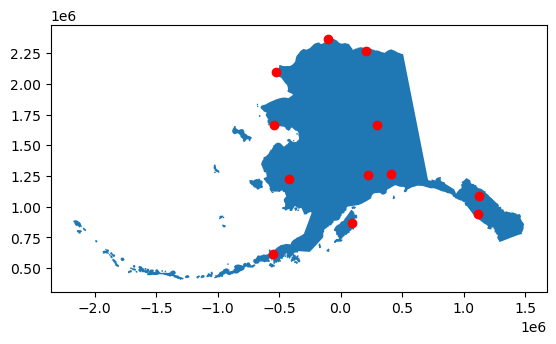

In [32]:
fig, ax = plt.subplots()

alaska.plot(ax = ax)
ak_places.plot(ax = ax, color = "red")
plt.show()

## Prepare roads data

In [33]:
roads.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
roads.head(3)

,scalerank,featurecla,type,sov_a3,note,edited,name,namealt,namealtt,routeraw,question,length_km,toll,ne_part,label,label2,local,localtype,localalt,labelrank,ignore,add,rwdb_rd_id,orig_fid,prefix,uident,continent,expressway,level,min_zoom,min_label,geometry
0,8,Road,Secondary Highway,CAN,None,"Version 1.5: Changed alignment, a few adds in ...",None,None,None,None,0,3,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,314705,North America,0,None,7.1,9.6,"LINESTRING (-133.32533 62.21571, -133.31664 62..."
1,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",83,None,None,None,0,164,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,108105,North America,0,Federal,7.0,8.6,"LINESTRING (-100.50543 42.80753, -100.53495 42..."
2,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",840,None,None,None,0,98,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,0,North America,0,U/C,7.0,9.5,"LINESTRING (-87.27432 36.02439, -87.22916 35.9..."


<Axes: >

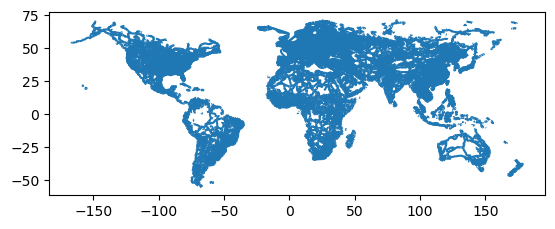

In [35]:
roads.plot()

Before clipping or reprojecting we will subset the data to select only US roads.

**BEST PRACTICE**
Reduce your tabular data before reducing via geometries.

<Axes: >

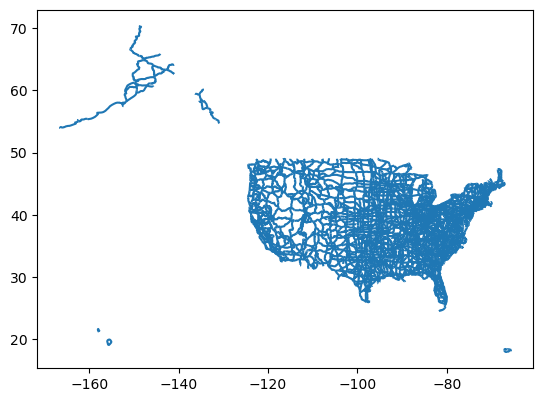

In [36]:
usa_roads = roads[roads.sov_a3 == "USA"]
usa_roads.plot()

We will now compose functions to clip `usa_roads` and `alaska` multipolygon.

In [37]:
# Clip roads to Alaska multipolygon
ak_roads = gpd.clip(usa_roads.to_crs(alaska.crs), alaska)

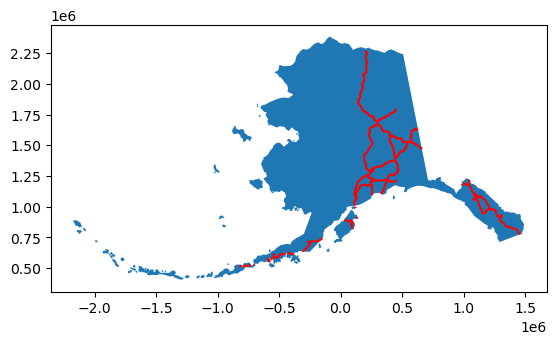

In [38]:
fig, ax = plt.subplots()
alaska.plot(ax = ax)
ak_roads.plot(ax = ax, color = "red")
plt.show()

## Clipping with a bounding box

We will clilp the `usa_roads` geo-dataframe with the **bounding box** of `alaska` instead of its polygons.

To create a bounding box, we will use the `box()` function from `shapely.geometry`. The syntax for the box is:

```python
box(minx, miny, maxx, maxy)
```

The output is a polygon representing a box constructed like this:

SHOW DIAGRAM.

If we want to create a `shapely` polygon from the bounds of a geo-df `gdf` we can use this syntax:

```python
box(*gbf.total_bounds)
```

In [39]:
alaska.total_bounds

array([-2175729.73162241,   404545.10791528,  1493082.30904445,
        2383808.43520816])

<class 'shapely.geometry.polygon.Polygon'>


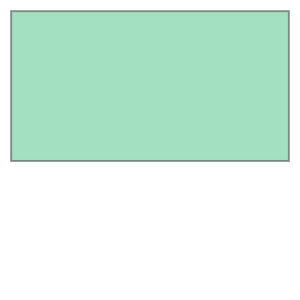

In [41]:
bbox = box(*alaska.total_bounds)
print(type(bbox))
bbox

### * = unpacking operator

In the last syntax we used an asterisk * as an **unpacking operator** on the array `alaska.total_bounds`. Think about it as unpacking the elements of `alaska.total_bounds` and passing them one-by-one to the parameters `minx`, `miny`, `maxx`, `maxy` of the `box()` function.

In [42]:
# Create a geo-dataframe from the bounding box
ak_bbox = gpd.GeoDataFrame(geometry = [bbox], # Assign geometry column
                          crs = alaska.crs) # Assign CRS

print(type(ak_bbox))
ak_bbox

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry
0,"POLYGON ((1493082.309 404545.108, 1493082.309 ..."


In [46]:
# Clip roads using Alaska bounding box

ak_complete_roads = gpd.clip(usa_roads.to_crs(ak_bbox.crs), ak_bbox)

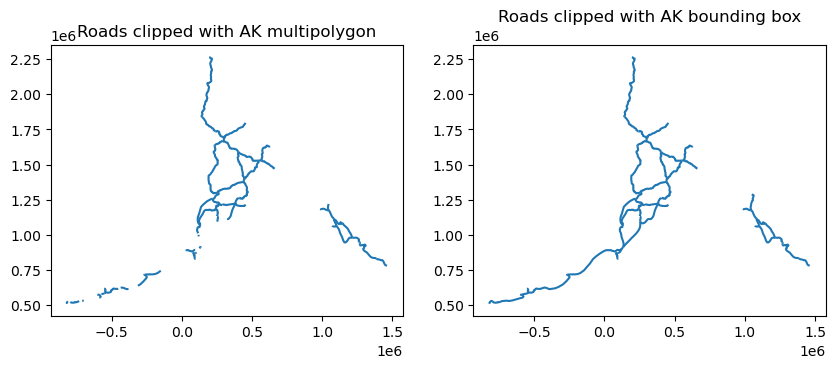

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

ak_roads.plot(ax = ax1)
ax1.set_title("Roads clipped with AK multipolygon")

ak_complete_roads.plot(ax = ax2)
ax2.set_title("Roads clipped with AK bounding box")

plt.show()

Let's plot all the layers together

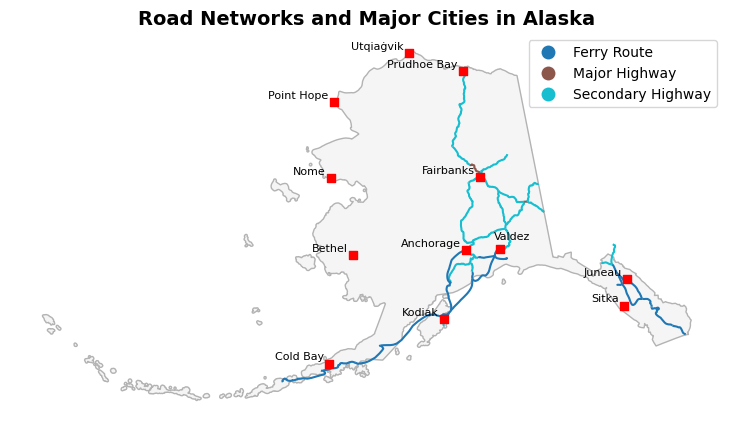

In [67]:
fig, ax = plt.subplots(figsize = (11, 5))
ax.axis("off")

alaska.plot(ax = ax,
           color = "whitesmoke",
           edgecolor = "0.7")

ak_complete_roads.plot(ax = ax,
                       zorder = 1, # Specify layer plotting order
                      column = "type",
                      legend = True)

ak_places.plot(ax = ax,
               zorder = 2,
              color = "red",
              marker = "s")

# Add city names as text annotations
for x, y, name in zip(ak_places.geometry.x, ak_places.geometry.y, ak_places['name']):
    if name != 'Valdez':
        ax.text(x-30000, y+20000, name, fontsize=8, ha = "right")

# Plot Valdex separately
valdez = ak_places[ak_places.name == "Valdez"]
ax.text(valdez.geometry.x.iloc[0]-30000, 
        valdez.geometry.y.iloc[0]+50000, 
        "Valdez", 
        fontsize=8, 
        ha = "left")

ax.set_title("Road Networks and Major Cities in Alaska", fontsize=14, fontweight='bold')

plt.show()